In [1]:
import mesa
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [12]:
# Set plot aesthetics

custom_settings = {
    "lines.linewidth": 0.8,
}

sns.set_theme(style='ticks', palette=["black"], rc=custom_settings)

In [18]:
# /*** CONFIG SECTION ***/

# Number of persons in household - approx percentage for 1,2...7 people in USA - from Statista
houseshold_sizes = [1,2,3,4,5,6,7]
houseshold_size_distribution = [0.28,0.36,0.15,0.12,0.06,0.02,0.01]

# Consumption rate: number of steps per person neded to consume 1 product
# E.g. a consumption rate of 3 means that a product is consumed by one person in 3 steps
# Concretely, that could mean a tube of toothpaste takes 3 weeks to use per person
# Consumption rates are defined statistically via absolute value of a normal distribution
base_consumption_rate = 3

# Pantry minimum percent (percent of household size)
pantry_min_percent = 0.1 # when pantry drops below 20% of household size, consumer must buy to replenish

# Base product price
base_product_price = 5

# Promo depths and frequencies
promo_depths=[1, 0.75, 0.5]
promo_frequencies=[0.5, 0.25, 0.25]


# Buying behaviors
# Just reference right now - not used in code yet, probably should make a dispatch table
buying_behaviors = ["buy_minimum", "buy_maximum", "buy_some_or_none", "buy_none"]

def get_pantry_max(household_size, pantry_min):
    '''
    Statistical assignment of maximum number of products a given household stocks
    Pantry min must be set before calling (default behavior of agent class)
    '''
    pantry_max = math.ceil(np.random.normal(household_size,1))
    if pantry_max < pantry_min:
        pantry_max = math.ceil(pantry_min)
    return pantry_max

def get_current_price(base_price, promo_depths=promo_depths, promo_frequencies=promo_frequencies):
    '''
    base_price: unitless number ("1" could be 1 dollar, 1 euro, etc.) 
    promo_depths: list of percentage discounts to be take off base 
    promo_frequencies: list of probabilities reflecting percentage of occasions depth will be applied
    
    Example: get_current_price(4.99, promo_depths=[1, 0.75, 0.5], promo_frequencies=[0.5,0.25,0.25])
    
    Above example will return a price that is 4.99 50% of the time, 3.74 and 2.50 25% of the time
    '''
    
    promo_depth = np.random.choice(promo_depths, p=promo_frequencies)
    current_price = base_price * promo_depth
    return current_price

def compute_total_purchases(model):
    '''Model-level KPI: sum of total purchases across agents each step'''
    purchases = [agent.purchased_this_step for agent in model.schedule.agents]
    return sum(purchases)

def compute_average_price(model):
    '''Model-level KPI: average product price each step'''
    prices = [agent.current_price for agent in model.schedule.agents]
    return np.mean(prices)

class ConsumerAgent(mesa.Agent):
    """Consumer of products"""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.household_size = np.random.choice(houseshold_sizes, p=houseshold_size_distribution)
        self.consumption_rate = abs(np.random.normal(base_consumption_rate,1)) # Applied at household level
        self.pantry_min = (self.household_size * pantry_min_percent) # Forces must-buy when stock drops percentage of household size
        self.pantry_max = get_pantry_max(self.household_size, self.pantry_min)
        self.pantry_stock = self.pantry_max # Start with a fully stocked pantry
        self.purchased_this_step = 0
        self.current_price = base_product_price
        self.last_product_price = base_product_price
        self.purchase_behavior = "buy_minimum"
        self.step_min = 0 # fewest number of products needed to bring stock above pantry minimum
        self.step_max = 0 

    def consume(self):
        self.pantry_stock = (self.pantry_stock - (self.household_size/self.consumption_rate))
        
    # Need to define a parametric model for purchase behavior and price sensitivity
    # Could pobably make this more readable in a dispatch table or other form
    def set_purchase_behavior(self):
        self.current_price = get_current_price(base_product_price)
        # Must buy something to restock if at or below min pantry
        if self.pantry_stock <= self.pantry_min:
            if self.current_price >= base_product_price:
                # Only buy min if at the bast product (e.g. ticket/msrp...) price
                self.purchase_behavior = "buy_minimum"
            elif self.current_price < self.last_product_price: # not great, should allow for more nuanced spending in this regime
                # Cheaper than last time? Great! Fully restock pantry
                self.purchase_behavior = "buy_maximum"
            else:
                # Not comparatively cheaper from last trip? Fine. Buy minimum and wait for next shopping trip.
                self.purchase_behvaior = "buy_minimum" # redundant but specific for all cases
        elif self.pantry_min < self.pantry_stock < self.pantry_max:
            if self.current_price >= base_product_price:
                # Not desperate (pantry not at min), roll the dice and maybe buy / mabye not
                self.purchase_behavior = "buy_some_or_none"
            elif self.current_price < self.last_product_price:
                # Ooo! Sale! Max out the pantry, whatever that may be
                self.purchase_behavior = "buy_maximum"
            else:
                # Not comparatively cheaper from last trip? Roll the dice and maybe buy / mabye not
                self.purchase_behavior = "buy_some_or_none"
        elif self.pantry_stock >= self.pantry_max:
            # Pantry is full, can't buy
            self.purchase_behavior = "buy_none"
           
    
    def purchase(self):
        self.purchased_this_step = 0 # Reset purchase count
        # Determine purchase needed this step to maintain pantry_min or above
        if self.pantry_stock <= self.pantry_min:
            self.step_min = math.ceil(self.pantry_min - self.pantry_stock)
        else:
            self.step_min = 0
        self.step_max = math.floor(self.pantry_max - self.pantry_stock) # set max possible purchase for step
        if self.purchase_behavior == "buy_minimum":
            self.purchased_this_step += self.step_min
        elif self.purchase_behavior == "buy_maximum":
            self.purchased_this_step += self.step_max
        elif self.purchase_behavior == "buy_some_or_none": # include 0 as a possible purchase even if pantry not full
            self.purchased_this_step += np.random.choice(list(range(0, (self.step_max + 1))))
        elif self.purchase_behavior == "buy_none":
            self.purchased_this_step += 0 # redundant but specific
        self.pantry_stock += self.purchased_this_step
                        
    
    def step(self):
        self.last_product_price = self.current_price
        self.consume()
        self.set_purchase_behavior()
        self.purchase()
            
class ConsumerModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = ConsumerAgent(i, self)
            self.schedule.add(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Total_Purchases": compute_total_purchases,
                "Average_Product_Price": compute_average_price
            },
            agent_reporters={
                "Household_Size": "household_size",
                "Purchased_This_Step": "purchased_this_step",
                "Pantry_Stock": "pantry_stock",
                "Pantry_Max": "pantry_max",
                "Pantry_Min": "pantry_min",
                "Purchase_Behavior": "purchase_behavior",
                "Minimum_Purchase_Needed": "step_min",
                "Current_Product_Price": "current_price",
                "Last_Product_Price": "last_product_price"
                
            }
        )

    def step(self):
        self.datacollector.collect(self)
        """Advance the model by one step and collect data"""
        self.schedule.step()

In [19]:
model = ConsumerModel(1000)

for i in range(100):
    model.step()

In [20]:
model_summary_df = model.datacollector.get_model_vars_dataframe()

In [21]:
model_summary_df

,Total_Purchases,Average_Product_Price
0,0,5.00000
1,717,4.13250
2,1112,4.04750
3,1239,4.12875
4,1318,4.06375
...,...,...
95,1305,3.99250
96,1312,4.06250
97,1296,4.09375
98,1292,4.06000


In [22]:
agent_summary_df = model.datacollector.get_agent_vars_dataframe()

In [28]:
agent_summary_df

Household_Size  Purchased_This_Step  Pantry_Stock  Pantry_Max  \
Step AgentID                                                                  
0    0                     1                    0      2.000000           2   
     1                     1                    0      1.000000           1   
     2                     2                    0      2.000000           2   
     3                     3                    0      3.000000           3   
     4                     2                    0      3.000000           3   
...                      ...                  ...           ...         ...   
99   995                   3                    0      2.152056           4   
     996                   1                    1      2.858677           3   
     997                   2                    1      0.481485           1   
     998                   1                    0      0.705481           1   
     999                   2                    1      1.935158           2   

              Pantry_Min Purchase_Behavior  Minimum_Purchase_Needed  \
Step AgentID                                                          
0    0               0.1       buy_minimum                        0   
     1               0.1       buy_minimum                        0   
     2               0.2       buy_minimum                        0   
     3               0.3       buy_minimum                        0   
     4               0.2       buy_minimum                        0   
...                  ...               ...                      ...   
99   995             0.3  buy_some_or_none                        0   
     996             0.1  buy_some_or_none                        0   
     997             0.2       buy_minimum                        1   
     998             0.1       buy_maximum                        0   
     999             0.2  buy_some_or_none                        0   

              Current_Product_Price  Last_Product_Price  
Step AgentID                                             
0    0                         5.00                5.00  
     1                         5.00                5.00  
     2                         5.00                5.00  
     3                         5.00                5.00  
     4                         5.00                5.00  
...                             ...                 ...  
99   995                       5.00                5.00  
     996                       5.00                5.00  
     997                       5.00                2.50  
     998                       3.75                5.00  
     999                       3.75                3.75  

[100000 rows x 9 columns]

In [24]:
agent_4 = agent_summary_df.xs(4,level="AgentID")

<Axes: xlabel='Average_Product_Price', ylabel='Total_Purchases'>

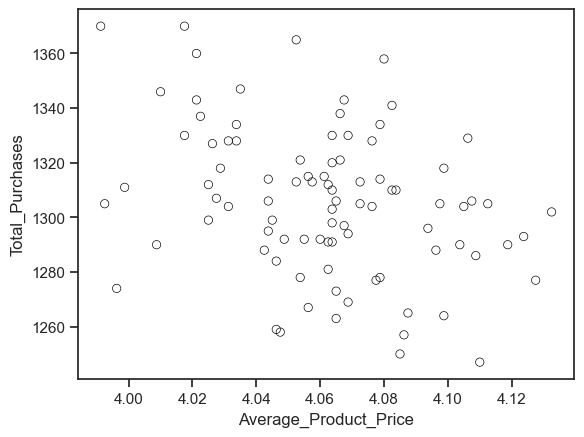

In [36]:
sns.scatterplot(data=model_summary_df[10:],x="Average_Product_Price", y="Total_Purchases", marker="o", facecolor="none", edgecolor="black")

<Axes: xlabel='Current_Product_Price', ylabel='Purchased_This_Step'>

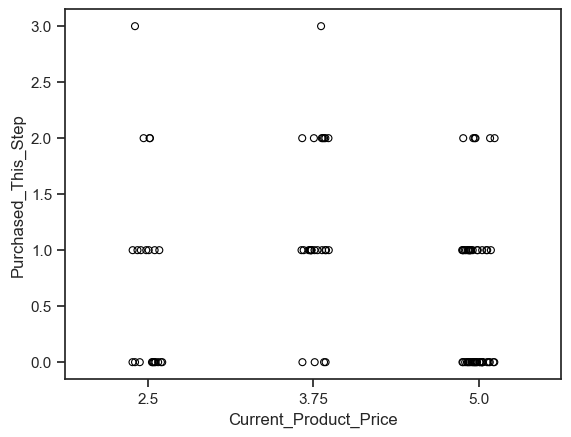

In [49]:
sns.stripplot(data=agent_4,x='Current_Product_Price',y='Purchased_This_Step', color="none", edgecolor="black", linewidth=0.8)

In [95]:
mod = smf.ols(formula='Total_Purchases ~ Average_Product_Price', data=model_summary_df[10:])

In [96]:
res = mod.fit()

In [97]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        Total_Purchases   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     11.61
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           0.000991
Time:                        16:27:04   Log-Likelihood:                -418.75
No. Observations:                  90   AIC:                             841.5
Df Residuals:                      88   BIC:                             846.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2499.33

In [98]:
consumer_mod = smf.ols(formula='Purchased_This_Step ~ Current_Product_Price', data=agent_summary_df.xs(4,level="AgentID")[10:])

In [101]:
consumer_res = consumer_mod.fit()

In [102]:
print(consumer_res.summary())

                             OLS Regression Results                            
Dep. Variable:     Purchased_This_Step   R-squared:                       0.014
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     1.221
Date:                 Mon, 13 Mar 2023   Prob (F-statistic):              0.272
Time:                         16:28:40   Log-Likelihood:                -104.91
No. Observations:                   90   AIC:                             213.8
Df Residuals:                       88   BIC:                             218.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [69]:
res.predict()

array([1310.27559253, 1309.90825738, 1300.35754367, 1316.15295481,
       1305.13290053, 1298.8882031 , 1300.72487881, 1301.4595491 ,
       1290.80682995, 1305.50023567, 1317.62229538, 1305.13290053,
       1305.86757081, 1298.15353281, 1308.43891681, 1311.01026281,
       1314.68361424, 1305.13290053, 1305.50023567, 1313.58160881,
       1304.76556538, 1304.39823024, 1311.01026281, 1304.0308951 ,
       1300.72487881, 1284.92946767, 1292.64350567, 1287.50081367,
       1302.56155453, 1318.72430081, 1324.96899824, 1293.37817595,
       1310.64292767, 1314.68361424, 1307.70424653, 1320.92831167,
       1321.29564681, 1294.84751653, 1308.43891681, 1304.76556538,
       1308.07158167, 1309.54092224, 1316.52028996, 1310.27559253,
       1324.23432796, 1286.39880824, 1305.13290053, 1318.72430081,
       1308.07158167, 1295.58218681, 1304.0308951 , 1306.96957624,
       1301.09221396, 1311.01026281, 1316.52028996, 1291.54150024,
       1326.43833881, 1304.39823024, 1305.13290053, 1307.33691

In [83]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

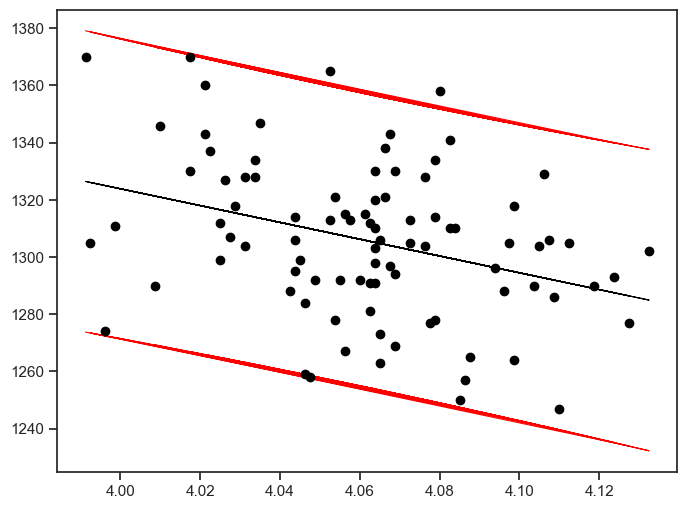

In [93]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dat['Average_Product_Price'], res.fittedvalues)
ax.plot(dat['Average_Product_Price'], iv_u, 'r-')
ax.plot(dat['Average_Product_Price'], iv_l, "r-")
ax.plot(dat['Average_Product_Price'], dat['Total_Purchases'],'o')

In [79]:
ax.plot(dat['Average_Product_Price'], res.predict())


/var/folders/vf/m4p5jj9s07x4v_df3mgg2fv40000gn/T/ipykernel_4287/4199988009.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [21]:
agent_dat = model.datacollector.get_agent_vars_dataframe()

In [22]:
agent_dat.head()

Household_Size  Purchased_This_Step  Pantry_Stock  Pantry_Max  \
Step AgentID                                                                  
0    0                     1                    0           2.0           2   
     1                     1                    0           2.0           2   
     2                     1                    0           1.0           1   
     3                     1                    0           2.0           2   
     4                     1                    0           2.0           2   

              Pantry_Min Purchase_Behavior  Minimum_Purchase_Needed  \
Step AgentID                                                          
0    0                 1       buy_minimum                        0   
     1                 1       buy_minimum                        0   
     2                 1       buy_minimum                        0   
     3                 1       buy_minimum                        0   
     4                 1       buy_minimum                        0   

              Current_Product_Price  Last_Produce_Price  
Step AgentID                                             
0    0                         2.50                5.00  
     1                         3.75                3.75  
     2                         2.50                5.00  
     3                         2.50                5.00  
     4                         5.00                5.00

In [23]:
total_purchases = model.datacollector.get_model_vars_dataframe()['Total_Purchases']
step_index = np.array((range(len(total_purchases))))

In [24]:
total_purchases_FFT = fft(total_purchases)

In [25]:
N = len(total_purchases)

Text(0.5, 0, 'Consumption Rates (steps per product)')

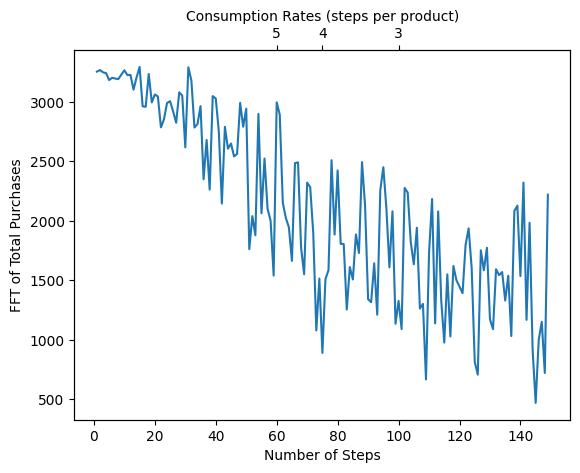

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(step_index[:N//2][1:],np.abs(total_purchases_FFT[:N//2][1:]))
ax1.set_xlabel(r"Number of Steps")
ax1.set_ylabel(r"FFT of Total Purchases")

new_tick_locations = [300/5,300/4,300/3]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([5,4,3])
ax2.set_xlabel(r"Consumption Rates (steps per product)")


In [103]:
model_summary_df.to_csv("model_summary.csv")

In [104]:
agent_summary_df.to_pickle("agent_summary.pkl")